We have 197 observations with 9 dimensions


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:82: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


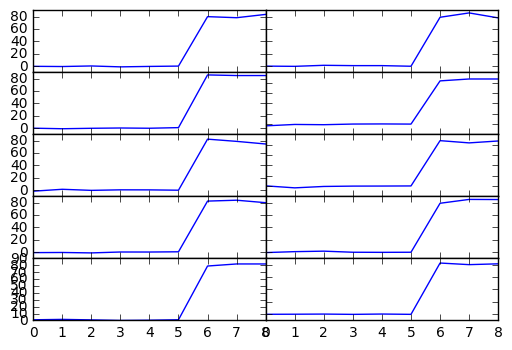

Train with approximately 6497 epochs


Conv_Layer_1:0
Conv1/bias_for_Conv_Layer_1:0
BatchNorm/beta:0
Conv_Layer_2:0
Conv2/bias_for_Conv_Layer_2:0
BatchNorm_1/beta:0
Fully_Connected_layer_1:0
Fully_Connected1/bias_for_Fully_Connected_Layer_1:0
W_fc2:0
Fully_Connected2/b_fc2:0
At     0/20000 Cost: train18.485 val0.633(18.485) Acc: train0.508 val0.400(0.508) 
At   200/20000 Cost: train2.347 val0.067(15.257) Acc: train0.497 val0.400(0.506) 
At   400/20000 Cost: train2.189 val0.059(12.644) Acc: train0.508 val0.400(0.506) 
At   600/20000 Cost: train2.160 val0.058(10.547) Acc: train0.508 val0.400(0.506) 
At   800/20000 Cost: train2.152 val0.057(8.868) Acc: train0.508 val0.400(0.507) 
At  1000/20000 Cost: train2.142 val0.056(7.523) Acc: train0.508 val0.400(0.507) 
At  1200/20000 Cost: train2.138 val0.056(6.446) Acc: train0.508 val0.400(0.507) 
At  1400/20000 Cost: train2.138 val0.056(5.584) Acc: train0.508 val0.400(0.507) 
At  1600/20000 Cost: train2.134 val0.056(4.894) Acc: train0.508 val0.400(0.507) 
At  1800/20000 Cost: train2.1

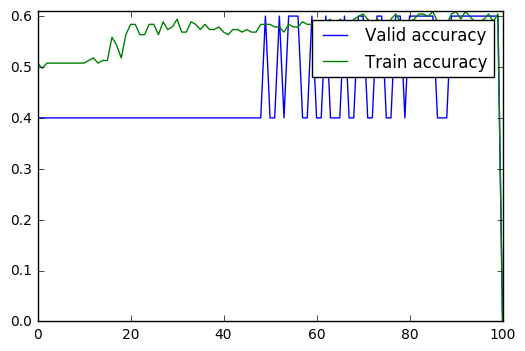

In [2]:
%reset -f
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops


"""Hyperparameters"""
num_filt_1 = 16     #Number of filters in first conv layer
num_filt_2 = 14      #Number of filters in second conv layer
num_filt_3 = 8      #Number of filters in thirs conv layer
num_fc_1 = 40       #Number of neurons in hully connected layer
max_iterations = 20000
batch_size = 64
dropout = 1.0       #Dropout rate in the fully connected layer
plot_row = 5        #How many rows do you want to plot in the visualization
learning_rate = 2e-5
input_norm = False   # Do you want z-score input normalization?

"""Load the data"""
# Datasets that were checked:
# "Two_Patterns" test-accuracy 0.999
# "ChlorineConcentration: test-accuracy 0.849
# Both of these accuracies are State-of-the-art as in this article
# "Multi-Scale Convolutional Neural Networks for Time Series Classification"
# Cui 2016 ArXiv
UCR = True
if UCR:
    #=====================================================================================================data
  #dataset = "ChlorineConcentration"
  #datadir = 'UCR_TS_Archive_2015/'+ dataset + '/' + dataset
  #data_train = np.loadtxt(datadir+'_TRAIN',delimiter=',')
  #data_test_val = np.loadtxt(datadir+'_TEST',delimiter=',')
  data_train = np.loadtxt('/data/traindata_IPS.txt',delimiter=',')
  data_test_val = np.loadtxt('/data/testdata_IPS.txt',delimiter=',')
else:
  data_train = np.loadtxt('data_train_dummy',delimiter=',')
  data_test_val = np.loadtxt('data_test_dummy',delimiter=',')
data_test,data_val = np.split(data_test_val,2)
# Usually, the first column contains the target labels
X_train = data_train[:,1:]
X_val = data_val[:,1:]
X_test = data_test[:,1:]
N = X_train.shape[0]
Ntest = X_test.shape[0]
D = X_train.shape[1]
y_train = data_train[:,0]
y_val = data_val[:,0]
y_test = data_test[:,0]
print('We have %s observations with %s dimensions'%(N,D))
# Organize the classes
num_classes = len(np.unique(y_train))
base = np.min(y_train)  #Check if data is 0-based
if base != 0:
    y_train -=base
    y_val -= base
    y_test -= base

if input_norm:
    mean = np.mean(X_train,axis=0)
    variance = np.var(X_train,axis=0)
    X_train -= mean
    #The 1e-9 avoids dividing by zero
    X_train /= np.sqrt(variance)+1e-9
    X_val -= mean
    X_val /= np.sqrt(variance)+1e-9
    X_test -= mean
    X_test /= np.sqrt(variance)+1e-9



if True:  #Set true if you want to visualize the actual time-series
    f, axarr = plt.subplots(plot_row, num_classes)
    for c in np.unique(y_train):    #Loops over classes, plot as columns
        ind = np.where(y_train == c)
        ind_plot = np.random.choice(ind[0],size=plot_row)
        for n in xrange(plot_row):  #Loops over rows
            axarr[n,c].plot(X_train[ind_plot[n],:])
            # Only shops axes for bottom row and left column
            if not n == plot_row-1:
                plt.setp([axarr[n,c].get_xticklabels()], visible=False)
            if not c == 0:
                plt.setp([axarr[n,c].get_yticklabels()], visible=False)
    f.subplots_adjust(hspace=0)  #No horizontal space between subplots
    f.subplots_adjust(wspace=0)  #No vertical space between subplots
    plt.show()


#Check for the input sizes
#assert (N>X_train.shape[1]), 'You are feeding a fat matrix for training, are you sure?'
#assert (Ntest>X_test.shape[1]), 'You are feeding a fat matrix for testing, are you sure?'

#Proclaim the epochs
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))

# Nodes for the input variables
x = tf.placeholder("float", shape=[None, D], name = 'Input_data')
y_ = tf.placeholder(tf.int64, shape=[None], name = 'Ground_truth')
keep_prob = tf.placeholder("float")
bn_train = tf.placeholder(tf.bool)          #Boolean value to guide batchnorm

# Define functions for initializing variables and standard layers
#For now, this seems superfluous, but in extending the code
#to many more layers, this will keep our code
#read-able

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name = name)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

with tf.name_scope("Reshaping_data") as scope:
  x_image = tf.reshape(x, [-1,D,1,1])

initializer = tf.contrib.layers.xavier_initializer()
"""Build the graph"""
# ewma is the decay for which we update the moving average of the
# mean and variance in the batch-norm layers
with tf.name_scope("Conv1") as scope:
  W_conv1 = tf.get_variable("Conv_Layer_1", shape=[5, 1, 1, num_filt_1],initializer=initializer)
  b_conv1 = bias_variable([num_filt_1], 'bias_for_Conv_Layer_1')
  a_conv1 = conv2d(x_image, W_conv1) + b_conv1

with tf.name_scope('Batch_norm_conv1') as scope:
    a_conv1 = tf.contrib.layers.batch_norm(a_conv1,is_training=bn_train,updates_collections=None)
    h_conv1 = tf.nn.relu(a_conv1)

with tf.name_scope("Conv2") as scope:
  W_conv2 = tf.get_variable("Conv_Layer_2", shape=[4, 1, num_filt_1, num_filt_2],initializer=initializer)
  b_conv2 = bias_variable([num_filt_2], 'bias_for_Conv_Layer_2')
  a_conv2 = conv2d(h_conv1, W_conv2) + b_conv2

with tf.name_scope('Batch_norm_conv2') as scope:
    a_conv2 = tf.contrib.layers.batch_norm(a_conv2,is_training=bn_train,updates_collections=None)
    h_conv2 = tf.nn.relu(a_conv2)

with tf.name_scope("Fully_Connected1") as scope:
  W_fc1 = tf.get_variable("Fully_Connected_layer_1", shape=[D*num_filt_2, num_fc_1],initializer=initializer)
  b_fc1 = bias_variable([num_fc_1], 'bias_for_Fully_Connected_Layer_1')
  h_conv3_flat = tf.reshape(h_conv2, [-1, D*num_filt_2])
  h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

with tf.name_scope("Fully_Connected2") as scope:
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
  W_fc2 = tf.get_variable("W_fc2", shape=[num_fc_1, num_classes],initializer=initializer)
  b_fc2 = tf.Variable(tf.constant(0.1, shape=[num_classes]),name = 'b_fc2')
  h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

with tf.name_scope("SoftMax") as scope:
#    regularizers = (tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(b_conv1) +
#                  tf.nn.l2_loss(W_conv2) + tf.nn.l2_loss(b_conv2) +
#                  tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(b_conv3) +
#                  tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) +
#                  tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2))
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(h_fc2,y_)
    cost = tf.reduce_sum(loss) / batch_size
#    cost += regularization*regularizers
    loss_summ = tf.scalar_summary("cross entropy_loss", cost)
with tf.name_scope("train") as scope:
    tvars = tf.trainable_variables()
    #We clip the gradients to prevent explosion
    grads = tf.gradients(cost, tvars)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = zip(grads, tvars)
    train_step = optimizer.apply_gradients(gradients)
    # The following block plots for every trainable variable
    #  - Histogram of the entries of the Tensor
    #  - Histogram of the gradient over the Tensor
    #  - Histogram of the grradient-norm over the Tensor
    numel = tf.constant([[0]])
    for gradient, variable in gradients:
      if isinstance(gradient, ops.IndexedSlices):
        grad_values = gradient.values
      else:
        grad_values = gradient

      numel +=tf.reduce_sum(tf.size(variable))

      h1 = tf.histogram_summary(variable.name, variable)
      h2 = tf.histogram_summary(variable.name + "/gradients", grad_values)
      h3 = tf.histogram_summary(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))
with tf.name_scope("Evaluating_accuracy") as scope:
    correct_prediction = tf.equal(tf.argmax(h_fc2,1), y_)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy_summary = tf.scalar_summary("accuracy", accuracy)


#Define one op to call all summaries
merged = tf.merge_all_summaries()

def print_tvars():
  tvars = tf.trainable_variables()
  for variable in tvars:
    print(variable.name)
  return
print_tvars()

# For now, we collect performances in a Numpy array.
# In future releases, I hope TensorBoard allows for more
# flexibility in plotting
perf_collect = np.zeros((3,int(np.floor(max_iterations /100))))
cost_ma = 0.0
acc_ma = 0.0
with tf.Session() as sess:
  writer = tf.train.SummaryWriter("/home/rob/Dropbox/ml_projects/CNN_tsc/log_tb", sess.graph_def)

  sess.run(tf.initialize_all_variables())

  step = 0      # Step is a counter for filling the numpy array perf_collect
  for i in range(max_iterations):
    batch_ind = np.random.choice(N,batch_size,replace=False)

    if i==0:
        # Use this line to check before-and-after test accuracy
        result = sess.run(accuracy, feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
        acc_test_before = result
    if i%200 == 0:
      #Check training performance
      result = sess.run([cost,accuracy],feed_dict = { x: X_train, y_: y_train, keep_prob: 1.0, bn_train : False})
      perf_collect[1,step] = acc_train = result[1]
      cost_train = result[0]

      #Check validation performance
      result = sess.run([accuracy,cost,merged], feed_dict={ x: X_val, y_: y_val, keep_prob: 1.0, bn_train : False})
      perf_collect[0,step] = acc_val = result[0]
      cost_val = result[1]
      if i == 0: cost_ma = cost_train
      if i == 0: acc_ma = acc_train
      cost_ma = 0.8*cost_ma+0.2*cost_train
      acc_ma = 0.8*acc_ma + 0.2*acc_train

      #Write information to TensorBoard
      writer.add_summary(result[2], i)
      writer.flush()  #Don't forget this command! It makes sure Python writes the summaries to the log-file
      print("At %5.0f/%5.0f Cost: train%5.3f val%5.3f(%5.3f) Acc: train%5.3f val%5.3f(%5.3f) " % (i,max_iterations, cost_train,cost_val,cost_ma,acc_train,acc_val,acc_ma))
      step +=1
    sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind], keep_prob: dropout, bn_train : True})
  result = sess.run([accuracy,numel], feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
  acc_test = result[0]
  print('The network has %s trainable parameters'%(result[1]))

"""Additional plots"""
print('The accuracy on the test data is %.3f, before training was %.3f' %(acc_test,acc_test_before))
plt.figure()
plt.plot(perf_collect[0],label='Valid accuracy')
plt.plot(perf_collect[1],label = 'Train accuracy')
plt.axis([0, step, 0, np.max(perf_collect)])
plt.legend()
plt.show()
# We can now open TensorBoard. Run the following line from your terminal
# tensorboard --logdir=/home/rob/Dropbox/ml_projetcs/CNN_tsc/log_tb

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


We have 197 observations with 6 dimensions


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:82: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


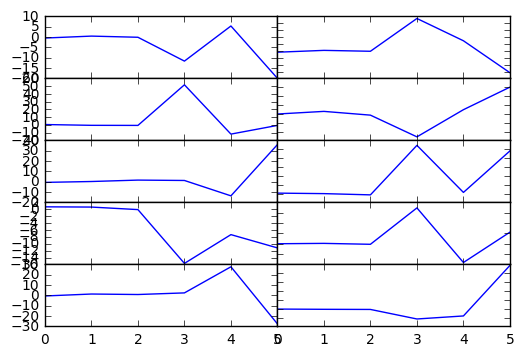

Train with approximately 6497 epochs


Conv_Layer_1:0
Conv1/bias_for_Conv_Layer_1:0
BatchNorm/beta:0
Conv_Layer_2:0
Conv2/bias_for_Conv_Layer_2:0
BatchNorm_1/beta:0
Fully_Connected_layer_1:0
Fully_Connected1/bias_for_Fully_Connected_Layer_1:0
W_fc2:0
Fully_Connected2/b_fc2:0
At     0/20000 Cost: train6.963 val0.086(6.963) Acc: train0.472 val0.400(0.472) 
At   200/20000 Cost: train2.512 val0.052(6.073) Acc: train0.462 val0.400(0.470) 
At   400/20000 Cost: train2.232 val0.054(5.305) Acc: train0.452 val0.400(0.466) 
At   600/20000 Cost: train2.159 val0.055(4.676) Acc: train0.482 val0.400(0.470) 
At   800/20000 Cost: train2.116 val0.055(4.164) Acc: train0.538 val0.600(0.483) 
At  1000/20000 Cost: train2.084 val0.055(3.748) Acc: train0.563 val0.600(0.499) 
At  1200/20000 Cost: train2.054 val0.054(3.409) Acc: train0.574 val0.800(0.514) 
At  1400/20000 Cost: train2.032 val0.052(3.134) Acc: train0.604 val0.600(0.532) 
At  1600/20000 Cost: train2.007 val0.050(2.908) Acc: train0.594 val0.800(0.544) 
At  1800/20000 Cost: train1.985 va

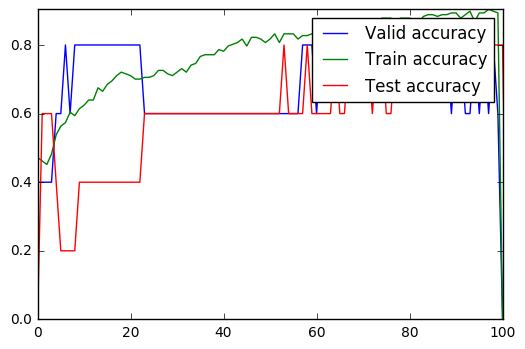

In [1]:
%reset -f
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops


"""Hyperparameters"""
num_filt_1 = 16     #Number of filters in first conv layer
num_filt_2 = 14      #Number of filters in second conv layer
num_filt_3 = 8      #Number of filters in thirs conv layer
num_fc_1 = 40       #Number of neurons in hully connected layer
max_iterations = 20000
batch_size = 64
dropout = 1.0       #Dropout rate in the fully connected layer
plot_row = 5        #How many rows do you want to plot in the visualization
learning_rate = 2e-5
input_norm = False   # Do you want z-score input normalization?

"""Load the data"""
# Datasets that were checked:
# "Two_Patterns" test-accuracy 0.999
# "ChlorineConcentration: test-accuracy 0.849
# Both of these accuracies are State-of-the-art as in this article
# "Multi-Scale Convolutional Neural Networks for Time Series Classification"
# Cui 2016 ArXiv
UCR = True
if UCR:
    #=====================================================================================================data++++++++best so far
  #dataset = "ChlorineConcentration"
  #datadir = 'UCR_TS_Archive_2015/'+ dataset + '/' + dataset
  #data_train = np.loadtxt(datadir+'_TRAIN',delimiter=',')
  #data_test_val = np.loadtxt(datadir+'_TEST',delimiter=',')
  data_train = np.loadtxt('/data/traindata_VP.txt',delimiter=',')
  data_test_val = np.loadtxt('/data/testdata_VP.txt',delimiter=',')
else:
  data_train = np.loadtxt('data_train_dummy',delimiter=',')
  data_test_val = np.loadtxt('data_test_dummy',delimiter=',')
data_test,data_val = np.split(data_test_val,2)
# Usually, the first column contains the target labels
X_train = data_train[:,1:]
X_val = data_val[:,1:]
X_test = data_test[:,1:]
N = X_train.shape[0]
Ntest = X_test.shape[0]
D = X_train.shape[1]
y_train = data_train[:,0]
y_val = data_val[:,0]
y_test = data_test[:,0]
print('We have %s observations with %s dimensions'%(N,D))
# Organize the classes
num_classes = len(np.unique(y_train))
base = np.min(y_train)  #Check if data is 0-based
if base != 0:
    y_train -=base
    y_val -= base
    y_test -= base

if input_norm:
    mean = np.mean(X_train,axis=0)
    variance = np.var(X_train,axis=0)
    X_train -= mean
    #The 1e-9 avoids dividing by zero
    X_train /= np.sqrt(variance)+1e-9
    X_val -= mean
    X_val /= np.sqrt(variance)+1e-9
    X_test -= mean
    X_test /= np.sqrt(variance)+1e-9



if True:  #Set true if you want to visualize the actual time-series
    f, axarr = plt.subplots(plot_row, num_classes)
    for c in np.unique(y_train):    #Loops over classes, plot as columns
        ind = np.where(y_train == c)
        ind_plot = np.random.choice(ind[0],size=plot_row)
        for n in xrange(plot_row):  #Loops over rows
            axarr[n,c].plot(X_train[ind_plot[n],:])
            # Only shops axes for bottom row and left column
            if not n == plot_row-1:
                plt.setp([axarr[n,c].get_xticklabels()], visible=False)
            if not c == 0:
                plt.setp([axarr[n,c].get_yticklabels()], visible=False)
    f.subplots_adjust(hspace=0)  #No horizontal space between subplots
    f.subplots_adjust(wspace=0)  #No vertical space between subplots
    plt.show()


#Check for the input sizes
#assert (N>X_train.shape[1]), 'You are feeding a fat matrix for training, are you sure?'
#assert (Ntest>X_test.shape[1]), 'You are feeding a fat matrix for testing, are you sure?'

#Proclaim the epochs
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))

# Nodes for the input variables
x = tf.placeholder("float", shape=[None, D], name = 'Input_data')
y_ = tf.placeholder(tf.int64, shape=[None], name = 'Ground_truth')
keep_prob = tf.placeholder("float")
bn_train = tf.placeholder(tf.bool)          #Boolean value to guide batchnorm

# Define functions for initializing variables and standard layers
#For now, this seems superfluous, but in extending the code
#to many more layers, this will keep our code
#read-able

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name = name)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

with tf.name_scope("Reshaping_data") as scope:
  x_image = tf.reshape(x, [-1,D,1,1])

initializer = tf.contrib.layers.xavier_initializer()
"""Build the graph"""
# ewma is the decay for which we update the moving average of the
# mean and variance in the batch-norm layers
with tf.name_scope("Conv1") as scope:
  W_conv1 = tf.get_variable("Conv_Layer_1", shape=[5, 1, 1, num_filt_1],initializer=initializer)
  b_conv1 = bias_variable([num_filt_1], 'bias_for_Conv_Layer_1')
  a_conv1 = conv2d(x_image, W_conv1) + b_conv1

with tf.name_scope('Batch_norm_conv1') as scope:
    a_conv1 = tf.contrib.layers.batch_norm(a_conv1,is_training=bn_train,updates_collections=None)
    h_conv1 = tf.nn.relu(a_conv1)

with tf.name_scope("Conv2") as scope:
  W_conv2 = tf.get_variable("Conv_Layer_2", shape=[4, 1, num_filt_1, num_filt_2],initializer=initializer)
  b_conv2 = bias_variable([num_filt_2], 'bias_for_Conv_Layer_2')
  a_conv2 = conv2d(h_conv1, W_conv2) + b_conv2

with tf.name_scope('Batch_norm_conv2') as scope:
    a_conv2 = tf.contrib.layers.batch_norm(a_conv2,is_training=bn_train,updates_collections=None)
    h_conv2 = tf.nn.relu(a_conv2)

with tf.name_scope("Fully_Connected1") as scope:
  W_fc1 = tf.get_variable("Fully_Connected_layer_1", shape=[D*num_filt_2, num_fc_1],initializer=initializer)
  b_fc1 = bias_variable([num_fc_1], 'bias_for_Fully_Connected_Layer_1')
  h_conv3_flat = tf.reshape(h_conv2, [-1, D*num_filt_2])
  h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

with tf.name_scope("Fully_Connected2") as scope:
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
  W_fc2 = tf.get_variable("W_fc2", shape=[num_fc_1, num_classes],initializer=initializer)
  b_fc2 = tf.Variable(tf.constant(0.1, shape=[num_classes]),name = 'b_fc2')
  h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

with tf.name_scope("SoftMax") as scope:
#    regularizers = (tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(b_conv1) +
#                  tf.nn.l2_loss(W_conv2) + tf.nn.l2_loss(b_conv2) +
#                  tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(b_conv3) +
#                  tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) +
#                  tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2))
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(h_fc2,y_)
    cost = tf.reduce_sum(loss) / batch_size
#    cost += regularization*regularizers
    loss_summ = tf.scalar_summary("cross entropy_loss", cost)
with tf.name_scope("train") as scope:
    tvars = tf.trainable_variables()
    #We clip the gradients to prevent explosion
    grads = tf.gradients(cost, tvars)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = zip(grads, tvars)
    train_step = optimizer.apply_gradients(gradients)
    # The following block plots for every trainable variable
    #  - Histogram of the entries of the Tensor
    #  - Histogram of the gradient over the Tensor
    #  - Histogram of the grradient-norm over the Tensor
    numel = tf.constant([[0]])
    for gradient, variable in gradients:
      if isinstance(gradient, ops.IndexedSlices):
        grad_values = gradient.values
      else:
        grad_values = gradient

      numel +=tf.reduce_sum(tf.size(variable))

      h1 = tf.histogram_summary(variable.name, variable)
      h2 = tf.histogram_summary(variable.name + "/gradients", grad_values)
      h3 = tf.histogram_summary(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))
with tf.name_scope("Evaluating_accuracy") as scope:
    correct_prediction = tf.equal(tf.argmax(h_fc2,1), y_)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy_summary = tf.scalar_summary("accuracy", accuracy)


#Define one op to call all summaries
merged = tf.merge_all_summaries()

def print_tvars():
  tvars = tf.trainable_variables()
  for variable in tvars:
    print(variable.name)
  return
print_tvars()

# For now, we collect performances in a Numpy array.
# In future releases, I hope TensorBoard allows for more
# flexibility in plotting
perf_collect = np.zeros((4,int(np.floor(max_iterations /100))))
cost_ma = 0.0
acc_ma = 0.0
with tf.Session() as sess:
  writer = tf.train.SummaryWriter("/home/rob/Dropbox/ml_projects/CNN_tsc/log_tb", sess.graph_def)

  sess.run(tf.initialize_all_variables())

  step = 0      # Step is a counter for filling the numpy array perf_collect
  for i in range(max_iterations):
    batch_ind = np.random.choice(N,batch_size,replace=False)

    if i==0:
        # Use this line to check before-and-after test accuracy
        result = sess.run(accuracy, feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
        acc_test_before = result
    if i%200 == 0:
      #Check training performance
      result = sess.run([cost,accuracy],feed_dict = { x: X_train, y_: y_train, keep_prob: 1.0, bn_train : False})
      perf_collect[1,step] = acc_train = result[1]
      cost_train = result[0]

      #Check validation performance
      result = sess.run([accuracy,cost,merged], feed_dict={ x: X_val, y_: y_val, keep_prob: 1.0, bn_train : False})
      perf_collect[0,step] = acc_val = result[0]
      cost_val = result[1]
      
     
      
      cost_val = result[1]
      if i == 0: cost_ma = cost_train
      if i == 0: acc_ma = acc_train
      cost_ma = 0.8*cost_ma+0.2*cost_train
      acc_ma = 0.8*acc_ma + 0.2*acc_train

      #Write information to TensorBoard
      writer.add_summary(result[2], i)
      writer.flush()  #Don't forget this command! It makes sure Python writes the summaries to the log-file
      print("At %5.0f/%5.0f Cost: train%5.3f val%5.3f(%5.3f) Acc: train%5.3f val%5.3f(%5.3f) " % (i,max_iterations, cost_train,cost_val,cost_ma,acc_train,acc_val,acc_ma))
      step +=1 
      
      #Check validation performance
      result = sess.run([accuracy,cost], feed_dict={  x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
      perf_collect[2,step] = acc_test = result[0]
      
    
    sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind], keep_prob: dropout, bn_train : True})
  result = sess.run([accuracy,numel], feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
  acc_test = result[0]
  print('The network has %s trainable parameters'%(result[1]))

"""Additional plots"""
print('The accuracy on the test data is %.3f, before training was %.3f' %(acc_test,acc_test_before))
plt.figure()
plt.plot(perf_collect[0],label='Valid accuracy')
plt.plot(perf_collect[1],label = 'Train accuracy')
plt.plot(perf_collect[2],label = 'Test accuracy')
plt.axis([0, step, 0, np.max(perf_collect)])
plt.legend()
plt.show()

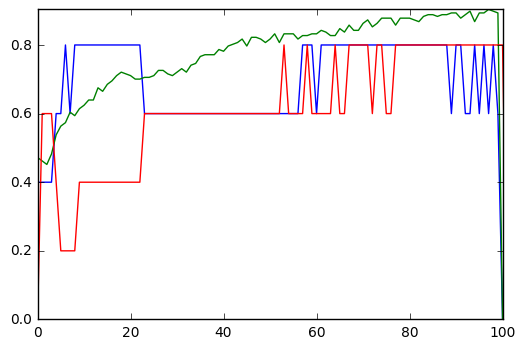

In [2]:
plt.figure()
plt.plot(perf_collect[0],label='Valid accuracy')
plt.plot(perf_collect[1],label = 'Train accuracy')
plt.plot(perf_collect[2],label = 'Test accuracy')
plt.axis([0, step, 0, np.max(perf_collect)])

plt.show()

We have 197 observations with 9 dimensions


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:82: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


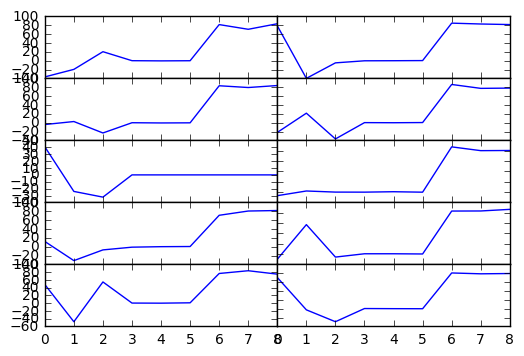

Train with approximately 6497 epochs


Conv_Layer_1:0
Conv1/bias_for_Conv_Layer_1:0
BatchNorm/beta:0
Conv_Layer_2:0
Conv2/bias_for_Conv_Layer_2:0
BatchNorm_1/beta:0
Fully_Connected_layer_1:0
Fully_Connected1/bias_for_Fully_Connected_Layer_1:0
W_fc2:0
Fully_Connected2/b_fc2:0
At     0/20000 Cost: train16.201 val0.486(16.201) Acc: train0.497 val0.400(0.497) 
At   200/20000 Cost: train2.734 val0.076(13.507) Acc: train0.508 val0.400(0.499) 
At   400/20000 Cost: train2.366 val0.062(11.279) Acc: train0.508 val0.400(0.501) 
At   600/20000 Cost: train2.240 val0.057(9.471) Acc: train0.523 val0.400(0.505) 
At   800/20000 Cost: train2.172 val0.055(8.011) Acc: train0.513 val0.400(0.507) 
At  1000/20000 Cost: train2.129 val0.054(6.835) Acc: train0.518 val0.600(0.509) 
At  1200/20000 Cost: train2.092 val0.053(5.886) Acc: train0.523 val0.600(0.512) 
At  1400/20000 Cost: train2.054 val0.052(5.120) Acc: train0.548 val0.600(0.519) 
At  1600/20000 Cost: train2.031 val0.051(4.502) Acc: train0.574 val0.600(0.530) 
At  1800/20000 Cost: train2.00

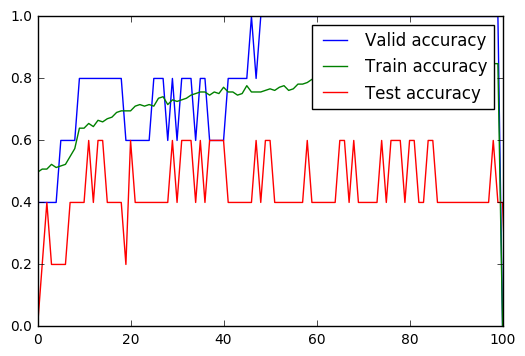

In [1]:
%reset -f
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops


"""Hyperparameters"""
num_filt_1 = 16     #Number of filters in first conv layer
num_filt_2 = 14      #Number of filters in second conv layer
num_filt_3 = 8      #Number of filters in thirs conv layer
num_fc_1 = 40       #Number of neurons in hully connected layer
max_iterations = 20000
batch_size = 64
dropout = 1.0       #Dropout rate in the fully connected layer
plot_row = 5        #How many rows do you want to plot in the visualization
learning_rate = 2e-5
input_norm = False   # Do you want z-score input normalization?

"""Load the data"""
# Datasets that were checked:
# "Two_Patterns" test-accuracy 0.999
# "ChlorineConcentration: test-accuracy 0.849
# Both of these accuracies are State-of-the-art as in this article
# "Multi-Scale Convolutional Neural Networks for Time Series Classification"
# Cui 2016 ArXiv
UCR = True
if UCR:
    #=====================================================================================================data
  #dataset = "ChlorineConcentration"
  #datadir = 'UCR_TS_Archive_2015/'+ dataset + '/' + dataset
  #data_train = np.loadtxt(datadir+'_TRAIN',delimiter=',')
  #data_test_val = np.loadtxt(datadir+'_TEST',delimiter=',')
  data_train = np.loadtxt('/data/traindata_VIS.txt',delimiter=',')
  data_test_val = np.loadtxt('/data/testdata_VIS.txt',delimiter=',')
else:
  data_train = np.loadtxt('data_train_dummy',delimiter=',')
  data_test_val = np.loadtxt('data_test_dummy',delimiter=',')
data_test,data_val = np.split(data_test_val,2)
# Usually, the first column contains the target labels
X_train = data_train[:,1:]
X_val = data_val[:,1:]
X_test = data_test[:,1:]
N = X_train.shape[0]
Ntest = X_test.shape[0]
D = X_train.shape[1]
y_train = data_train[:,0]
y_val = data_val[:,0]
y_test = data_test[:,0]
print('We have %s observations with %s dimensions'%(N,D))
# Organize the classes
num_classes = len(np.unique(y_train))
base = np.min(y_train)  #Check if data is 0-based
if base != 0:
    y_train -=base
    y_val -= base
    y_test -= base

if input_norm:
    mean = np.mean(X_train,axis=0)
    variance = np.var(X_train,axis=0)
    X_train -= mean
    #The 1e-9 avoids dividing by zero
    X_train /= np.sqrt(variance)+1e-9
    X_val -= mean
    X_val /= np.sqrt(variance)+1e-9
    X_test -= mean
    X_test /= np.sqrt(variance)+1e-9



if True:  #Set true if you want to visualize the actual time-series
    f, axarr = plt.subplots(plot_row, num_classes)
    for c in np.unique(y_train):    #Loops over classes, plot as columns
        ind = np.where(y_train == c)
        ind_plot = np.random.choice(ind[0],size=plot_row)
        for n in xrange(plot_row):  #Loops over rows
            axarr[n,c].plot(X_train[ind_plot[n],:])
            # Only shops axes for bottom row and left column
            if not n == plot_row-1:
                plt.setp([axarr[n,c].get_xticklabels()], visible=False)
            if not c == 0:
                plt.setp([axarr[n,c].get_yticklabels()], visible=False)
    f.subplots_adjust(hspace=0)  #No horizontal space between subplots
    f.subplots_adjust(wspace=0)  #No vertical space between subplots
    plt.show()


#Check for the input sizes
#assert (N>X_train.shape[1]), 'You are feeding a fat matrix for training, are you sure?'
#assert (Ntest>X_test.shape[1]), 'You are feeding a fat matrix for testing, are you sure?'

#Proclaim the epochs
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))

# Nodes for the input variables
x = tf.placeholder("float", shape=[None, D], name = 'Input_data')
y_ = tf.placeholder(tf.int64, shape=[None], name = 'Ground_truth')
keep_prob = tf.placeholder("float")
bn_train = tf.placeholder(tf.bool)          #Boolean value to guide batchnorm

# Define functions for initializing variables and standard layers
#For now, this seems superfluous, but in extending the code
#to many more layers, this will keep our code
#read-able

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name = name)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

with tf.name_scope("Reshaping_data") as scope:
  x_image = tf.reshape(x, [-1,D,1,1])

initializer = tf.contrib.layers.xavier_initializer()
"""Build the graph"""
# ewma is the decay for which we update the moving average of the
# mean and variance in the batch-norm layers
with tf.name_scope("Conv1") as scope:
  W_conv1 = tf.get_variable("Conv_Layer_1", shape=[5, 1, 1, num_filt_1],initializer=initializer)
  b_conv1 = bias_variable([num_filt_1], 'bias_for_Conv_Layer_1')
  a_conv1 = conv2d(x_image, W_conv1) + b_conv1

with tf.name_scope('Batch_norm_conv1') as scope:
    a_conv1 = tf.contrib.layers.batch_norm(a_conv1,is_training=bn_train,updates_collections=None)
    h_conv1 = tf.nn.relu(a_conv1)

with tf.name_scope("Conv2") as scope:
  W_conv2 = tf.get_variable("Conv_Layer_2", shape=[4, 1, num_filt_1, num_filt_2],initializer=initializer)
  b_conv2 = bias_variable([num_filt_2], 'bias_for_Conv_Layer_2')
  a_conv2 = conv2d(h_conv1, W_conv2) + b_conv2

with tf.name_scope('Batch_norm_conv2') as scope:
    a_conv2 = tf.contrib.layers.batch_norm(a_conv2,is_training=bn_train,updates_collections=None)
    h_conv2 = tf.nn.relu(a_conv2)

with tf.name_scope("Fully_Connected1") as scope:
  W_fc1 = tf.get_variable("Fully_Connected_layer_1", shape=[D*num_filt_2, num_fc_1],initializer=initializer)
  b_fc1 = bias_variable([num_fc_1], 'bias_for_Fully_Connected_Layer_1')
  h_conv3_flat = tf.reshape(h_conv2, [-1, D*num_filt_2])
  h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

with tf.name_scope("Fully_Connected2") as scope:
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
  W_fc2 = tf.get_variable("W_fc2", shape=[num_fc_1, num_classes],initializer=initializer)
  b_fc2 = tf.Variable(tf.constant(0.1, shape=[num_classes]),name = 'b_fc2')
  h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

with tf.name_scope("SoftMax") as scope:
#    regularizers = (tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(b_conv1) +
#                  tf.nn.l2_loss(W_conv2) + tf.nn.l2_loss(b_conv2) +
#                  tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(b_conv3) +
#                  tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) +
#                  tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2))
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(h_fc2,y_)
    cost = tf.reduce_sum(loss) / batch_size
#    cost += regularization*regularizers
    loss_summ = tf.scalar_summary("cross entropy_loss", cost)
with tf.name_scope("train") as scope:
    tvars = tf.trainable_variables()
    #We clip the gradients to prevent explosion
    grads = tf.gradients(cost, tvars)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = zip(grads, tvars)
    train_step = optimizer.apply_gradients(gradients)
    # The following block plots for every trainable variable
    #  - Histogram of the entries of the Tensor
    #  - Histogram of the gradient over the Tensor
    #  - Histogram of the grradient-norm over the Tensor
    numel = tf.constant([[0]])
    for gradient, variable in gradients:
      if isinstance(gradient, ops.IndexedSlices):
        grad_values = gradient.values
      else:
        grad_values = gradient

      numel +=tf.reduce_sum(tf.size(variable))

      h1 = tf.histogram_summary(variable.name, variable)
      h2 = tf.histogram_summary(variable.name + "/gradients", grad_values)
      h3 = tf.histogram_summary(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))
with tf.name_scope("Evaluating_accuracy") as scope:
    correct_prediction = tf.equal(tf.argmax(h_fc2,1), y_)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy_summary = tf.scalar_summary("accuracy", accuracy)


#Define one op to call all summaries
merged = tf.merge_all_summaries()

def print_tvars():
  tvars = tf.trainable_variables()
  for variable in tvars:
    print(variable.name)
  return
print_tvars()

# For now, we collect performances in a Numpy array.
# In future releases, I hope TensorBoard allows for more
# flexibility in plotting
perf_collect = np.zeros((4,int(np.floor(max_iterations /100))))
cost_ma = 0.0
acc_ma = 0.0
with tf.Session() as sess:
  writer = tf.train.SummaryWriter("/home/rob/Dropbox/ml_projects/CNN_tsc/log_tb", sess.graph_def)

  sess.run(tf.initialize_all_variables())

  step = 0      # Step is a counter for filling the numpy array perf_collect
  for i in range(max_iterations):
    batch_ind = np.random.choice(N,batch_size,replace=False)

    if i==0:
        # Use this line to check before-and-after test accuracy
        result = sess.run(accuracy, feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
        acc_test_before = result
    if i%200 == 0:
      #Check training performance
      result = sess.run([cost,accuracy],feed_dict = { x: X_train, y_: y_train, keep_prob: 1.0, bn_train : False})
      perf_collect[1,step] = acc_train = result[1]
      cost_train = result[0]

      #Check validation performance
      result = sess.run([accuracy,cost,merged], feed_dict={ x: X_val, y_: y_val, keep_prob: 1.0, bn_train : False})
      perf_collect[0,step] = acc_val = result[0]
      cost_val = result[1]
      
     
      
      cost_val = result[1]
      if i == 0: cost_ma = cost_train
      if i == 0: acc_ma = acc_train
      cost_ma = 0.8*cost_ma+0.2*cost_train
      acc_ma = 0.8*acc_ma + 0.2*acc_train

      #Write information to TensorBoard
      writer.add_summary(result[2], i)
      writer.flush()  #Don't forget this command! It makes sure Python writes the summaries to the log-file
      print("At %5.0f/%5.0f Cost: train%5.3f val%5.3f(%5.3f) Acc: train%5.3f val%5.3f(%5.3f) " % (i,max_iterations, cost_train,cost_val,cost_ma,acc_train,acc_val,acc_ma))
      step +=1 
      
      #Check validation performance
      result = sess.run([accuracy,cost], feed_dict={  x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
      perf_collect[2,step] = acc_test = result[0]
      
    
    sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind], keep_prob: dropout, bn_train : True})
  result = sess.run([accuracy,numel], feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
  acc_test = result[0]
  print('The network has %s trainable parameters'%(result[1]))

"""Additional plots"""
print('The accuracy on the test data is %.3f, before training was %.3f' %(acc_test,acc_test_before))
plt.figure()
plt.plot(perf_collect[0],label='Valid accuracy')
plt.plot(perf_collect[1],label = 'Train accuracy')
plt.plot(perf_collect[2],label = 'Test accuracy')
plt.axis([0, step, 0, np.max(perf_collect)])
plt.legend()
plt.show()

We have 197 observations with 4 dimensions


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:82: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


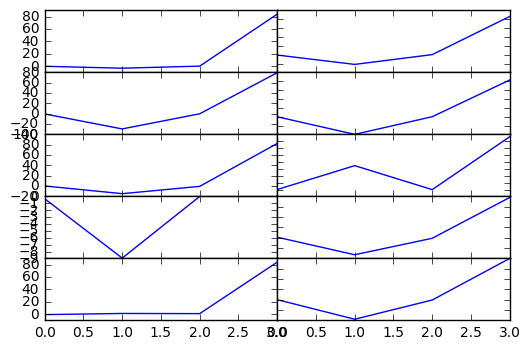

Train with approximately 6497 epochs


Conv_Layer_1:0
Conv1/bias_for_Conv_Layer_1:0
BatchNorm/beta:0
Conv_Layer_2:0
Conv2/bias_for_Conv_Layer_2:0
BatchNorm_1/beta:0
Fully_Connected_layer_1:0
Fully_Connected1/bias_for_Fully_Connected_Layer_1:0
W_fc2:0
Fully_Connected2/b_fc2:0
At     0/20000 Cost: train5.508 val0.103(5.508) Acc: train0.482 val0.800(0.482) 
At   200/20000 Cost: train2.383 val0.049(4.883) Acc: train0.477 val0.800(0.481) 
At   400/20000 Cost: train2.262 val0.050(4.359) Acc: train0.477 val0.800(0.480) 
At   600/20000 Cost: train2.208 val0.050(3.929) Acc: train0.452 val0.800(0.475) 
At   800/20000 Cost: train2.167 val0.051(3.577) Acc: train0.457 val0.600(0.471) 
At  1000/20000 Cost: train2.140 val0.052(3.289) Acc: train0.487 val0.600(0.474) 
At  1200/20000 Cost: train2.131 val0.051(3.058) Acc: train0.513 val0.600(0.482) 
At  1400/20000 Cost: train2.122 val0.050(2.870) Acc: train0.508 val1.000(0.487) 
At  1600/20000 Cost: train2.117 val0.049(2.720) Acc: train0.558 val0.800(0.501) 
At  1800/20000 Cost: train2.111 va

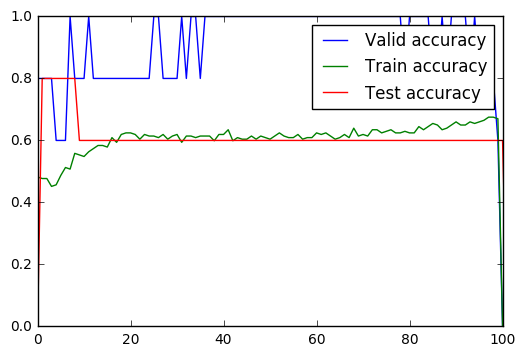

In [1]:
%reset -f
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops


"""Hyperparameters"""
num_filt_1 = 16     #Number of filters in first conv layer
num_filt_2 = 14      #Number of filters in second conv layer
num_filt_3 = 8      #Number of filters in thirs conv layer
num_fc_1 = 40       #Number of neurons in hully connected layer
max_iterations = 20000
batch_size = 64
dropout = 1.0       #Dropout rate in the fully connected layer
plot_row = 5        #How many rows do you want to plot in the visualization
learning_rate = 2e-5
input_norm = False   # Do you want z-score input normalization?

"""Load the data"""
# Datasets that were checked:
# "Two_Patterns" test-accuracy 0.999
# "ChlorineConcentration: test-accuracy 0.849
# Both of these accuracies are State-of-the-art as in this article
# "Multi-Scale Convolutional Neural Networks for Time Series Classification"
# Cui 2016 ArXiv
UCR = True
if UCR:
    #=====================================================================================================data
  #dataset = "ChlorineConcentration"
  #datadir = 'UCR_TS_Archive_2015/'+ dataset + '/' + dataset
  #data_train = np.loadtxt(datadir+'_TRAIN',delimiter=',')
  #data_test_val = np.loadtxt(datadir+'_TEST',delimiter=',')
  data_train = np.loadtxt('/data/traindata_NoLag.txt',delimiter=',')
  data_test_val = np.loadtxt('/data/testdata_NoLag.txt',delimiter=',')
else:
  data_train = np.loadtxt('data_train_dummy',delimiter=',')
  data_test_val = np.loadtxt('data_test_dummy',delimiter=',')
data_test,data_val = np.split(data_test_val,2)
# Usually, the first column contains the target labels
X_train = data_train[:,1:]
X_val = data_val[:,1:]
X_test = data_test[:,1:]
N = X_train.shape[0]
Ntest = X_test.shape[0]
D = X_train.shape[1]
y_train = data_train[:,0]
y_val = data_val[:,0]
y_test = data_test[:,0]
print('We have %s observations with %s dimensions'%(N,D))
# Organize the classes
num_classes = len(np.unique(y_train))
base = np.min(y_train)  #Check if data is 0-based
if base != 0:
    y_train -=base
    y_val -= base
    y_test -= base

if input_norm:
    mean = np.mean(X_train,axis=0)
    variance = np.var(X_train,axis=0)
    X_train -= mean
    #The 1e-9 avoids dividing by zero
    X_train /= np.sqrt(variance)+1e-9
    X_val -= mean
    X_val /= np.sqrt(variance)+1e-9
    X_test -= mean
    X_test /= np.sqrt(variance)+1e-9



if True:  #Set true if you want to visualize the actual time-series
    f, axarr = plt.subplots(plot_row, num_classes)
    for c in np.unique(y_train):    #Loops over classes, plot as columns
        ind = np.where(y_train == c)
        ind_plot = np.random.choice(ind[0],size=plot_row)
        for n in xrange(plot_row):  #Loops over rows
            axarr[n,c].plot(X_train[ind_plot[n],:])
            # Only shops axes for bottom row and left column
            if not n == plot_row-1:
                plt.setp([axarr[n,c].get_xticklabels()], visible=False)
            if not c == 0:
                plt.setp([axarr[n,c].get_yticklabels()], visible=False)
    f.subplots_adjust(hspace=0)  #No horizontal space between subplots
    f.subplots_adjust(wspace=0)  #No vertical space between subplots
    plt.show()


#Check for the input sizes
#assert (N>X_train.shape[1]), 'You are feeding a fat matrix for training, are you sure?'
#assert (Ntest>X_test.shape[1]), 'You are feeding a fat matrix for testing, are you sure?'

#Proclaim the epochs
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))

# Nodes for the input variables
x = tf.placeholder("float", shape=[None, D], name = 'Input_data')
y_ = tf.placeholder(tf.int64, shape=[None], name = 'Ground_truth')
keep_prob = tf.placeholder("float")
bn_train = tf.placeholder(tf.bool)          #Boolean value to guide batchnorm

# Define functions for initializing variables and standard layers
#For now, this seems superfluous, but in extending the code
#to many more layers, this will keep our code
#read-able

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name = name)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

with tf.name_scope("Reshaping_data") as scope:
  x_image = tf.reshape(x, [-1,D,1,1])

initializer = tf.contrib.layers.xavier_initializer()
"""Build the graph"""
# ewma is the decay for which we update the moving average of the
# mean and variance in the batch-norm layers
with tf.name_scope("Conv1") as scope:
  W_conv1 = tf.get_variable("Conv_Layer_1", shape=[5, 1, 1, num_filt_1],initializer=initializer)
  b_conv1 = bias_variable([num_filt_1], 'bias_for_Conv_Layer_1')
  a_conv1 = conv2d(x_image, W_conv1) + b_conv1

with tf.name_scope('Batch_norm_conv1') as scope:
    a_conv1 = tf.contrib.layers.batch_norm(a_conv1,is_training=bn_train,updates_collections=None)
    h_conv1 = tf.nn.relu(a_conv1)

with tf.name_scope("Conv2") as scope:
  W_conv2 = tf.get_variable("Conv_Layer_2", shape=[4, 1, num_filt_1, num_filt_2],initializer=initializer)
  b_conv2 = bias_variable([num_filt_2], 'bias_for_Conv_Layer_2')
  a_conv2 = conv2d(h_conv1, W_conv2) + b_conv2

with tf.name_scope('Batch_norm_conv2') as scope:
    a_conv2 = tf.contrib.layers.batch_norm(a_conv2,is_training=bn_train,updates_collections=None)
    h_conv2 = tf.nn.relu(a_conv2)

with tf.name_scope("Fully_Connected1") as scope:
  W_fc1 = tf.get_variable("Fully_Connected_layer_1", shape=[D*num_filt_2, num_fc_1],initializer=initializer)
  b_fc1 = bias_variable([num_fc_1], 'bias_for_Fully_Connected_Layer_1')
  h_conv3_flat = tf.reshape(h_conv2, [-1, D*num_filt_2])
  h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

with tf.name_scope("Fully_Connected2") as scope:
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
  W_fc2 = tf.get_variable("W_fc2", shape=[num_fc_1, num_classes],initializer=initializer)
  b_fc2 = tf.Variable(tf.constant(0.1, shape=[num_classes]),name = 'b_fc2')
  h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

with tf.name_scope("SoftMax") as scope:
#    regularizers = (tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(b_conv1) +
#                  tf.nn.l2_loss(W_conv2) + tf.nn.l2_loss(b_conv2) +
#                  tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(b_conv3) +
#                  tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) +
#                  tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2))
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(h_fc2,y_)
    cost = tf.reduce_sum(loss) / batch_size
#    cost += regularization*regularizers
    loss_summ = tf.scalar_summary("cross entropy_loss", cost)
with tf.name_scope("train") as scope:
    tvars = tf.trainable_variables()
    #We clip the gradients to prevent explosion
    grads = tf.gradients(cost, tvars)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = zip(grads, tvars)
    train_step = optimizer.apply_gradients(gradients)
    # The following block plots for every trainable variable
    #  - Histogram of the entries of the Tensor
    #  - Histogram of the gradient over the Tensor
    #  - Histogram of the grradient-norm over the Tensor
    numel = tf.constant([[0]])
    for gradient, variable in gradients:
      if isinstance(gradient, ops.IndexedSlices):
        grad_values = gradient.values
      else:
        grad_values = gradient

      numel +=tf.reduce_sum(tf.size(variable))

      h1 = tf.histogram_summary(variable.name, variable)
      h2 = tf.histogram_summary(variable.name + "/gradients", grad_values)
      h3 = tf.histogram_summary(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))
with tf.name_scope("Evaluating_accuracy") as scope:
    correct_prediction = tf.equal(tf.argmax(h_fc2,1), y_)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy_summary = tf.scalar_summary("accuracy", accuracy)


#Define one op to call all summaries
merged = tf.merge_all_summaries()

def print_tvars():
  tvars = tf.trainable_variables()
  for variable in tvars:
    print(variable.name)
  return
print_tvars()

# For now, we collect performances in a Numpy array.
# In future releases, I hope TensorBoard allows for more
# flexibility in plotting
perf_collect = np.zeros((4,int(np.floor(max_iterations /100))))
cost_ma = 0.0
acc_ma = 0.0
with tf.Session() as sess:
  writer = tf.train.SummaryWriter("/home/rob/Dropbox/ml_projects/CNN_tsc/log_tb", sess.graph_def)

  sess.run(tf.initialize_all_variables())

  step = 0      # Step is a counter for filling the numpy array perf_collect
  for i in range(max_iterations):
    batch_ind = np.random.choice(N,batch_size,replace=False)

    if i==0:
        # Use this line to check before-and-after test accuracy
        result = sess.run(accuracy, feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
        acc_test_before = result
    if i%200 == 0:
      #Check training performance
      result = sess.run([cost,accuracy],feed_dict = { x: X_train, y_: y_train, keep_prob: 1.0, bn_train : False})
      perf_collect[1,step] = acc_train = result[1]
      cost_train = result[0]

      #Check validation performance
      result = sess.run([accuracy,cost,merged], feed_dict={ x: X_val, y_: y_val, keep_prob: 1.0, bn_train : False})
      perf_collect[0,step] = acc_val = result[0]
      cost_val = result[1]
      
     
      
      cost_val = result[1]
      if i == 0: cost_ma = cost_train
      if i == 0: acc_ma = acc_train
      cost_ma = 0.8*cost_ma+0.2*cost_train
      acc_ma = 0.8*acc_ma + 0.2*acc_train

      #Write information to TensorBoard
      writer.add_summary(result[2], i)
      writer.flush()  #Don't forget this command! It makes sure Python writes the summaries to the log-file
      print("At %5.0f/%5.0f Cost: train%5.3f val%5.3f(%5.3f) Acc: train%5.3f val%5.3f(%5.3f) " % (i,max_iterations, cost_train,cost_val,cost_ma,acc_train,acc_val,acc_ma))
      step +=1 
      
      #Check validation performance
      result = sess.run([accuracy,cost], feed_dict={  x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
      perf_collect[2,step] = acc_test = result[0]
      
    
    sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind], keep_prob: dropout, bn_train : True})
  result = sess.run([accuracy,numel], feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
  acc_test = result[0]
  print('The network has %s trainable parameters'%(result[1]))

"""Additional plots"""
print('The accuracy on the test data is %.3f, before training was %.3f' %(acc_test,acc_test_before))
plt.figure()
plt.plot(perf_collect[0],label='Valid accuracy')
plt.plot(perf_collect[1],label = 'Train accuracy')
plt.plot(perf_collect[2],label = 'Test accuracy')
plt.axis([0, step, 0, np.max(perf_collect)])
plt.legend()
plt.show()

[[  1.           0.78615962   0.99245663  -1.02161346   1.67798918
  -33.58020704   3.10303143  -5.22619822  -6.44817456   0.333       78.333     ]
 [  2.          -0.46801475   0.78615962   0.99245663  -1.02161346
   -3.79013708 -33.58020704   3.10303143  -5.22619822   0.          80.        ]
 [  1.           1.41065465  -0.46801475   0.78615962   0.99245663
   44.49088933  -3.79013708 -33.58020704   3.10303143   0.          88.        ]
 [  2.          -0.85007557   1.41065465  -0.46801475   0.78615962
    0.84969287  44.49088933  -3.79013708 -33.58020704  -0.5         80.5       ]]
We have 197 observations with 10 dimensions


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:80: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:85: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


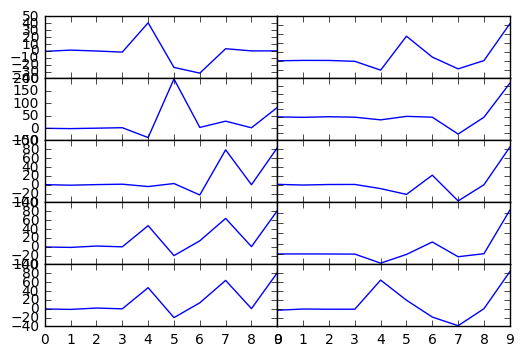

Train with approximately 3248 epochs


Conv_Layer_1:0
Conv1/bias_for_Conv_Layer_1:0
BatchNorm/beta:0
Conv_Layer_2:0
Conv2/bias_for_Conv_Layer_2:0
BatchNorm_1/beta:0
Fully_Connected_layer_1:0
Fully_Connected1/bias_for_Fully_Connected_Layer_1:0
W_fc2:0
Fully_Connected2/b_fc2:0
At     0/10000 Cost: train10.450 val0.198(10.450) Acc: train0.497 val0.500(0.497) 
At   200/10000 Cost: train2.330 val0.063(8.826) Acc: train0.472 val0.250(0.492) 
At   400/10000 Cost: train2.194 val0.056(7.500) Acc: train0.492 val0.250(0.492) 
At   600/10000 Cost: train2.126 val0.052(6.425) Acc: train0.508 val0.250(0.495) 
At   800/10000 Cost: train2.076 val0.049(5.555) Acc: train0.548 val0.250(0.506) 
At  1000/10000 Cost: train2.028 val0.047(4.850) Acc: train0.599 val0.500(0.525) 
At  1200/10000 Cost: train1.979 val0.045(4.275) Acc: train0.645 val0.500(0.549) 
At  1400/10000 Cost: train1.932 val0.042(3.807) Acc: train0.650 val0.500(0.569) 
At  1600/10000 Cost: train1.891 val0.040(3.424) Acc: train0.675 val0.750(0.590) 
At  1800/10000 Cost: train1.847 

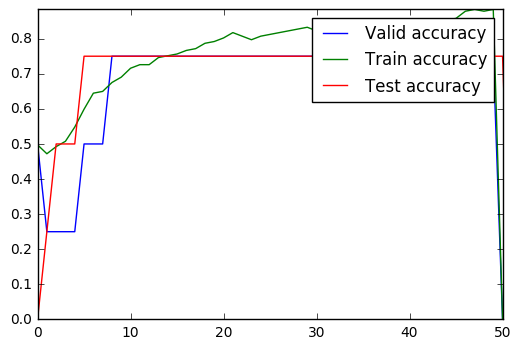

In [1]:
#         GE  oct lag 4 1,1
%reset -f
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops


"""Hyperparameters"""
num_filt_1 = 16     #Number of filters in first conv layer
num_filt_2 = 14      #Number of filters in second conv layer
num_filt_3 = 8      #Number of filters in thirs conv layer
num_fc_1 = 40       #Number of neurons in hully connected layer
max_iterations = 10000
batch_size = 64
dropout = 1.0       #Dropout rate in the fully connected layer
plot_row = 5        #How many rows do you want to plot in the visualization
learning_rate = 2e-5
input_norm = False   # Do you want z-score input normalization?

"""Load the data"""
# Datasets that were checked:
# "Two_Patterns" test-accuracy 0.999
# "ChlorineConcentration: test-accuracy 0.849
# Both of these accuracies are State-of-the-art as in this article
# "Multi-Scale Convolutional Neural Networks for Time Series Classification"
# Cui 2016 ArXiv
UCR = True
if UCR:
    #=====================================================================================================data---not that bad
  #dataset = "ChlorineConcentration"
  #datadir = 'UCR_TS_Archive_2015/'+ dataset + '/' + dataset
  #data_train = np.loadtxt(datadir+'_TRAIN',delimiter=',')
  #data_test_val = np.loadtxt(datadir+'_TEST',delimiter=',')
  data_train = np.loadtxt('/data/traindata_PVS1I1.txt',delimiter=',')
  data_test_val = np.loadtxt('/data/testdata_PVS1I1.txt',delimiter=',')
else:
  data_train = np.loadtxt('data_train_dummy',delimiter=',')
  data_test_val = np.loadtxt('data_test_dummy',delimiter=',')
data_test,data_val = np.split(data_test_val,2)
print data_val
# Usually, the first column contains the target labels
X_train = data_train[:,1:]
X_val = data_val[:,1:]
X_test = data_test[:,1:]
N = X_train.shape[0]
Ntest = X_test.shape[0]
D = X_train.shape[1]
y_train = data_train[:,0]
y_val = data_val[:,0]
y_test = data_test[:,0]
print('We have %s observations with %s dimensions'%(N,D))
# Organize the classes
num_classes = len(np.unique(y_train))
base = np.min(y_train)  #Check if data is 0-based
if base != 0:
    y_train -=base
    y_val -= base
    y_test -= base

if input_norm:
    mean = np.mean(X_train,axis=0)
    variance = np.var(X_train,axis=0)
    X_train -= mean
    #The 1e-9 avoids dividing by zero
    X_train /= np.sqrt(variance)+1e-9
    X_val -= mean
    X_val /= np.sqrt(variance)+1e-9
    X_test -= mean
    X_test /= np.sqrt(variance)+1e-9



if True:  #Set true if you want to visualize the actual time-series
    f, axarr = plt.subplots(plot_row, num_classes)
    for c in np.unique(y_train):    #Loops over classes, plot as columns
        ind = np.where(y_train == c)
        ind_plot = np.random.choice(ind[0],size=plot_row)
        for n in xrange(plot_row):  #Loops over rows
            axarr[n,c].plot(X_train[ind_plot[n],:])
            # Only shops axes for bottom row and left column
            if not n == plot_row-1:
                plt.setp([axarr[n,c].get_xticklabels()], visible=False)
            if not c == 0:
                plt.setp([axarr[n,c].get_yticklabels()], visible=False)
    f.subplots_adjust(hspace=0)  #No horizontal space between subplots
    f.subplots_adjust(wspace=0)  #No vertical space between subplots
    plt.show()


#Check for the input sizes
#assert (N>X_train.shape[1]), 'You are feeding a fat matrix for training, are you sure?'
#assert (Ntest>X_test.shape[1]), 'You are feeding a fat matrix for testing, are you sure?'

#Proclaim the epochs
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))

# Nodes for the input variables
x = tf.placeholder("float", shape=[None, D], name = 'Input_data')
y_ = tf.placeholder(tf.int64, shape=[None], name = 'Ground_truth')
keep_prob = tf.placeholder("float")
bn_train = tf.placeholder(tf.bool)          #Boolean value to guide batchnorm

# Define functions for initializing variables and standard layers
#For now, this seems superfluous, but in extending the code
#to many more layers, this will keep our code
#read-able

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name = name)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

with tf.name_scope("Reshaping_data") as scope:
  x_image = tf.reshape(x, [-1,D,1,1])

initializer = tf.contrib.layers.xavier_initializer()
"""Build the graph"""
# ewma is the decay for which we update the moving average of the
# mean and variance in the batch-norm layers
with tf.name_scope("Conv1") as scope:
  W_conv1 = tf.get_variable("Conv_Layer_1", shape=[5, 1, 1, num_filt_1],initializer=initializer)
  b_conv1 = bias_variable([num_filt_1], 'bias_for_Conv_Layer_1')
  a_conv1 = conv2d(x_image, W_conv1) + b_conv1

with tf.name_scope('Batch_norm_conv1') as scope:
    a_conv1 = tf.contrib.layers.batch_norm(a_conv1,is_training=bn_train,updates_collections=None)
    h_conv1 = tf.nn.relu(a_conv1)

with tf.name_scope("Conv2") as scope:
  W_conv2 = tf.get_variable("Conv_Layer_2", shape=[4, 1, num_filt_1, num_filt_2],initializer=initializer)
  b_conv2 = bias_variable([num_filt_2], 'bias_for_Conv_Layer_2')
  a_conv2 = conv2d(h_conv1, W_conv2) + b_conv2

with tf.name_scope('Batch_norm_conv2') as scope:
    a_conv2 = tf.contrib.layers.batch_norm(a_conv2,is_training=bn_train,updates_collections=None)
    h_conv2 = tf.nn.relu(a_conv2)

with tf.name_scope("Fully_Connected1") as scope:
  W_fc1 = tf.get_variable("Fully_Connected_layer_1", shape=[D*num_filt_2, num_fc_1],initializer=initializer)
  b_fc1 = bias_variable([num_fc_1], 'bias_for_Fully_Connected_Layer_1')
  h_conv3_flat = tf.reshape(h_conv2, [-1, D*num_filt_2])
  h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

with tf.name_scope("Fully_Connected2") as scope:
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
  W_fc2 = tf.get_variable("W_fc2", shape=[num_fc_1, num_classes],initializer=initializer)
  b_fc2 = tf.Variable(tf.constant(0.1, shape=[num_classes]),name = 'b_fc2')
  h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

with tf.name_scope("SoftMax") as scope:
#    regularizers = (tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(b_conv1) +
#                  tf.nn.l2_loss(W_conv2) + tf.nn.l2_loss(b_conv2) +
#                  tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(b_conv3) +
#                  tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) +
#                  tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2))
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(h_fc2,y_)
    cost = tf.reduce_sum(loss) / batch_size
#    cost += regularization*regularizers
    loss_summ = tf.scalar_summary("cross entropy_loss", cost)
with tf.name_scope("train") as scope:
    tvars = tf.trainable_variables()
    #We clip the gradients to prevent explosion
    grads = tf.gradients(cost, tvars)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = zip(grads, tvars)
    train_step = optimizer.apply_gradients(gradients)
    # The following block plots for every trainable variable
    #  - Histogram of the entries of the Tensor
    #  - Histogram of the gradient over the Tensor
    #  - Histogram of the grradient-norm over the Tensor
    numel = tf.constant([[0]])
    for gradient, variable in gradients:
      if isinstance(gradient, ops.IndexedSlices):
        grad_values = gradient.values
      else:
        grad_values = gradient

      numel +=tf.reduce_sum(tf.size(variable))

      h1 = tf.histogram_summary(variable.name, variable)
      h2 = tf.histogram_summary(variable.name + "/gradients", grad_values)
      h3 = tf.histogram_summary(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))
with tf.name_scope("Evaluating_accuracy") as scope:
    correct_prediction = tf.equal(tf.argmax(h_fc2,1), y_)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy_summary = tf.scalar_summary("accuracy", accuracy)


#Define one op to call all summaries
merged = tf.merge_all_summaries()

def print_tvars():
  tvars = tf.trainable_variables()
  for variable in tvars:
    print(variable.name)
  return
print_tvars()

# For now, we collect performances in a Numpy array.
# In future releases, I hope TensorBoard allows for more
# flexibility in plotting
perf_collect = np.zeros((4,int(np.floor(max_iterations /100))))
cost_ma = 0.0
acc_ma = 0.0
with tf.Session() as sess:
  writer = tf.train.SummaryWriter("/home/rob/Dropbox/ml_projects/CNN_tsc/log_tb", sess.graph_def)

  sess.run(tf.initialize_all_variables())

  step = 0      # Step is a counter for filling the numpy array perf_collect
  for i in range(max_iterations):
    batch_ind = np.random.choice(N,batch_size,replace=False)

    if i==0:
        # Use this line to check before-and-after test accuracy
        result = sess.run(accuracy, feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
        acc_test_before = result
    if i%200 == 0:
      #Check training performance
      result = sess.run([cost,accuracy],feed_dict = { x: X_train, y_: y_train, keep_prob: 1.0, bn_train : False})
      perf_collect[1,step] = acc_train = result[1]
      cost_train = result[0]

      #Check validation performance
      result = sess.run([accuracy,cost,merged], feed_dict={ x: X_val, y_: y_val, keep_prob: 1.0, bn_train : False})
      perf_collect[0,step] = acc_val = result[0]
      cost_val = result[1]
      
     
      
      cost_val = result[1]
      if i == 0: cost_ma = cost_train
      if i == 0: acc_ma = acc_train
      cost_ma = 0.8*cost_ma+0.2*cost_train
      acc_ma = 0.8*acc_ma + 0.2*acc_train

      #Write information to TensorBoard
      writer.add_summary(result[2], i)
      writer.flush()  #Don't forget this command! It makes sure Python writes the summaries to the log-file
      print("At %5.0f/%5.0f Cost: train%5.3f val%5.3f(%5.3f) Acc: train%5.3f val%5.3f(%5.3f) " % (i,max_iterations, cost_train,cost_val,cost_ma,acc_train,acc_val,acc_ma))
      step +=1 
      
      #Check validation performance
      result = sess.run([accuracy,cost], feed_dict={  x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
      perf_collect[2,step] = acc_test = result[0]
      
    
    sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind], keep_prob: dropout, bn_train : True})
  result = sess.run([accuracy,numel], feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
  acc_test = result[0]
  print('The network has %s trainable parameters'%(result[1]))

"""Additional plots"""
print('The accuracy on the test data is %.3f, before training was %.3f' %(acc_test,acc_test_before))
plt.figure()
plt.plot(perf_collect[0],label='Valid accuracy')
plt.plot(perf_collect[1],label = 'Train accuracy')
plt.plot(perf_collect[2],label = 'Test accuracy')
plt.axis([0, step, 0, np.max(perf_collect)])
plt.legend()
plt.show()

The accuracy on the test data is 0.600, before training was 0.800


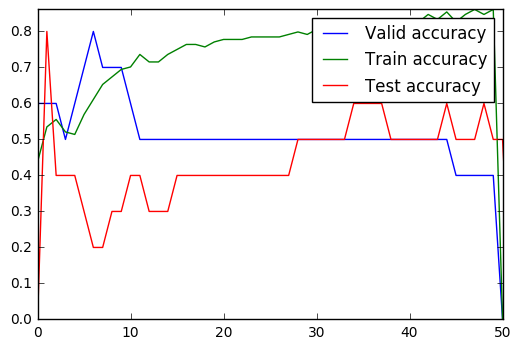

In [2]:
# three lag all variable 
print('The accuracy on the test data is %.3f, before training was %.3f' %(acc_test,acc_test_before))
plt.figure()
plt.plot(perf_collect[0],label='Valid accuracy')
plt.plot(perf_collect[1],label = 'Train accuracy')
plt.plot(perf_collect[2],label = 'Test accuracy')
plt.axis([0, step, 0, np.max(perf_collect)])
plt.legend()
plt.show()

[[  3.13114000e+07   3.67499550e-02   8.00000000e-01 ...,  -7.27288065e-02
   -3.34901348e+01   1.00000000e+00]
 [  3.88286000e+07  -9.55180035e-01   1.00000000e+00 ...,  -8.00579190e-01
    6.47714248e+00  -1.00000000e+00]
 [  3.44192000e+07  -8.53115433e-01   0.00000000e+00 ...,   1.10055687e-01
   -1.57668122e+01  -1.00000000e+00]
 ..., 
 [  2.88297000e+07  -8.50075566e-01   0.00000000e+00 ...,   9.92456632e-01
    3.10303143e+00  -1.00000000e+00]
 [  2.61738000e+07   3.89743010e-02  -5.00000000e-01 ...,   7.86159618e-01
   -3.35802070e+01   1.00000000e+00]
 [  3.99515000e+07   5.45381833e-01   1.00000000e+00 ...,  -4.68014747e-01
   -3.79013708e+00   1.00000000e+00]]


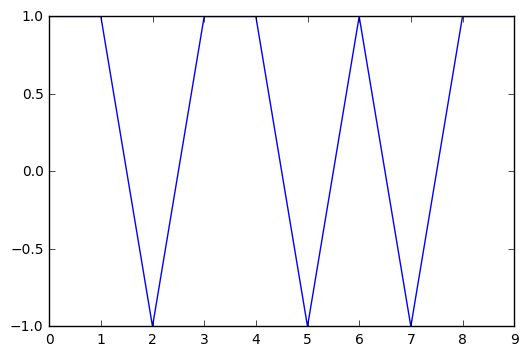

In [13]:
data_train = np.loadtxt('/data/snpret.txt',delimiter=',')
#d=pd.array(data_train["Today"])
print data_train
plt.plot(data_train[:,-1][-10:])
plt.show()

In [5]:
%who()


No variables match your requested type.
